### PIDs and using wpilib's PID controller - 2021 1212 CJH
#### this is more about PIDs than physics and python but you get all three
---

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

#import wpilib
#from wpimath import controller

#### Say you want to set the temperature at a setpoint you choose
* You could controll it manually
* You could set up a controller to do it for you
* You have to think about how to tell the controller to work
* Furnace picture from https://www.techbriefs.com/

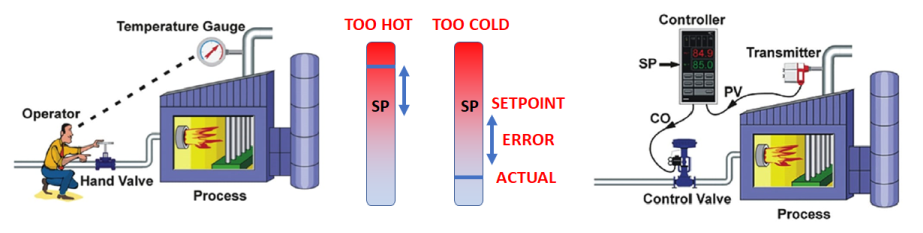

#### If you had a simple thermostat with a switch ("on-off controller"), you'd get a temperature that looks like this:
(from Eurotherm's site)

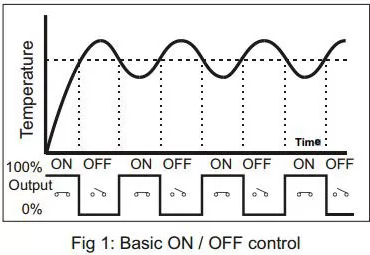

---
### We can do better --
#### the standard PID control equation looks like this:
## ${u(t)} = K_p e(t) + K_i \int e(t)\, dt + K_d \frac{de}{dt}$
#### or, since computers rarely actually do calculus,
## ${u(t)} = K_p e(t) + K_i \sum \limits _{j=1} ^{n} e(t_j){\Delta}t + K_d \frac{(e(t)-e(t-{\Delta}t))}{{\Delta}t}$
Where
* u(t) is the output of the controller - usually power from -100% to 100%
* e(t) is the **error** = **(setpoint - measured value)** at time t
* and the gains, which the user inputs to the model, are
  * Kp is the **proportional gain** - the farther away from the setpoint, the more power is applied (like a spring)
  * Ki is the **integral gain** - the sum of all of the old errors times the time between measurements
  * Kd is the **derivative gain** - looks at the change in the error **(error now - previous error)** and slows you down - (like a shock absorber)
 * It's a loop, so it looks like the picture below


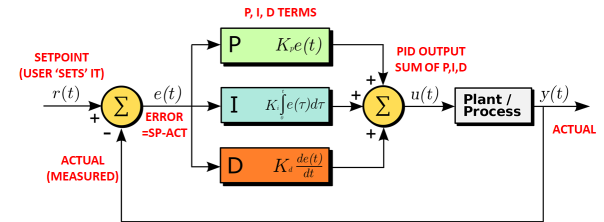

### Do some simple tests with static models

In [25]:
def clamp(value: float, bottom: float, top: float) -> float:
    return max(bottom, min(value, top))

In [28]:
clamp(-5.5, -1, 1)

-1

### How about an elevator acting under gravity
* calculate PID response for a simple elevator
* elevator is acted on by an acceleration **a** (down) and a motor (pid output * motor_scale * a) up 
* each loop we calculate
  * acceleration (y_tt), velocity (y_t) and position (y)
  * the error, the sum of the error and the change in error
  * the pid response

In [29]:
# simulate a PID controller
def calc_pids(kp=0, ki=0, kd=0, ffwd=0, setpoint=7, y_0=0, motor_scale=2):

    # set up the array of times
    x = np.linspace(0,10,100) # ten seconds of data
    dt = x[1]-x[0]

    # set the initial conditions, using _t and _tt to denote time derivatives
    # that means y_t is velocity and y_tt is acceleration
    y = y_0
    y_t = 0

    setpoint = setpoint  # passed in as a parameter
    sum_error = 0
    previous_error = 0
    a = 10  # 9.8 m/s/s - gravity

    # initialize the two arrays we calculate
    position = []
    velocity = []
    accel = []
    pid = []

    # calculate the error and position at each point
    for t in x:
        # calculate PID terms and output
        error = setpoint - y
        sum_error += error
        output = ffwd + kp * error + ki * sum_error * dt + kd * (error-previous_error)/dt
        output = clamp(output, -1, 1)
        previous_error = error

        # update the model - forces, velocity, position
        y_tt = -a + (motor_scale * a * output)  # simple model, make the motor 2x gravity at full power
        y_t += y_tt * dt  # velocity is acceleration * time
        y += y_t * dt  # distance is velocity * time
        
        # impose a hard limit at the ground - boundary conditions
        y = 0 if y < 0 else y
        y_t = 0 if y <= 0 else y_t

        position.append(y)
        velocity.append(y_t)
        pid.append(output)
        accel.append(y_tt)
        
    return x, position, velocity, pid, accel

In [30]:
# this just plots the data from above
def plot_elevator(kp=0, ki=0, kd=0, ffwd=0, setpoint=7, y_0=0, motor_scale=2, label='', autoscale=False):
    
    x, position, velocity, pid, accel = calc_pids(kp=kp, ki=ki, kd=kd, ffwd=ffwd, setpoint=setpoint, y_0=y_0, motor_scale=motor_scale)
    #start the figure
    fig = plt.figure(figsize=(12,8))
    # set height ratios for subplots
    gs = gridspec.GridSpec(4, 1, height_ratios=[2, 1, 1, 1]) 

    # the first subplot
    ax1 = plt.subplot(gs[0])
    line_1, = ax1.plot(x, position, color='g', label='position')
    ax1.axhline(y=setpoint, color='g', lw=1, linestyle='--', label='setpoint')

    ax2 = plt.subplot(gs[1])
    line_2, = ax2.plot(x, velocity, color='b', label='velocity')
    ax2.axhline(y=0, color='b', lw=1, linestyle='--', label='')

    ax3 = plt.subplot(gs[2])
    line_3, = ax3.plot(x, accel, color='r', label='acceleration')
    
    ax4 = plt.subplot(gs[3])
    line_4, = ax4.plot(x, pid, color='k', label='PID')


    # format the chart
    ax1.set_title(f'{label} (kp={kp},ki={ki},kd={kd}) PID output,  setpoint = {setpoint}', fontsize=14)
    ax1.set_ylabel('measured position', color='g', fontsize=14)
    if autoscale:
        pass
    else:
        ax1.set_ylim([0,max(10, np.asarray(position).max())])
    ax2.set_ylabel('velocity', color='b', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax3.set_ylabel('accel', color='r', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax4.set_ylabel('PID', color='k', fontsize=14, rotation=90, ha='center', labelpad=0)
    ax4.set_xlabel(f'time', fontsize=14)
    # ax2.set_xticks([])
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    
    [ax.legend(loc='lower right', prop={'size': 12}) for ax in [ax1, ax2, ax3, ax4]]
    # remove vertical gap between subplots
    plt.subplots_adjust(hspace=0.1)

    return fig

#### now use the model to simulate an elevator
---

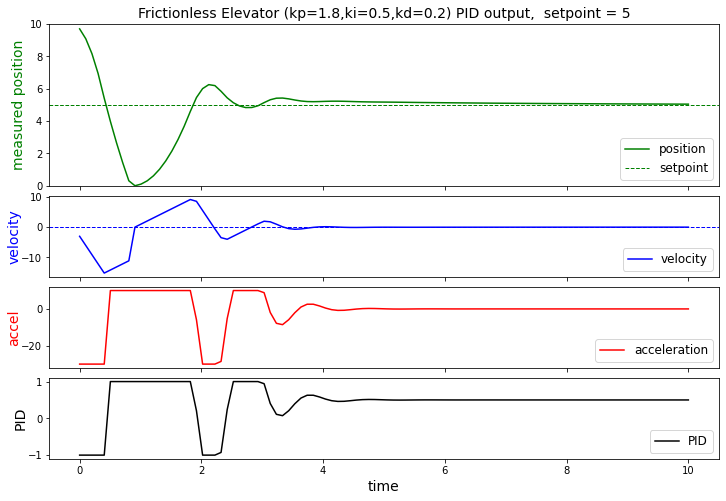

In [42]:
# initial conditions - you start at the setpoint
setpoint = 5
y_0 = 5

# set the gains
# kp, ki, kd = 100, 0, 0  # on-off switch, full power
# kp, ki, kd = 0.5, 0, 0 # on-off switch, wimpy - notice where you max out

# kp, ki, kd  = 0.5, 1.0, 0.0  # out of control integral
# kp, ki, kd = 0.9, 0.2, 0.1  # happy but needs several seconds
kp, ki, kd = 1.8, 0.5, 0.2  # better

# what if we were starting elsewhere?
y_0 = 10
# kp, ki, kd = 1.8, 0.5, 0.2  # huh

# run the simulation
_ = plot_elevator(kp=kp, ki=ki, kd=kd, setpoint=setpoint, y_0=y_0, label='Frictionless Elevator', motor_scale=2, autoscale=False)

---
#### fix the elevator - gravity is not your friend.  fight it with a "constant" term called feed-forward
## ${u(t)} = K_p e(t) + K_i \sum \limits _{j=1} ^{n} e(t_j){\Delta}t + K_d \frac{(e(t)-e(t-{\Delta}t))}{{\Delta}t} + FF$

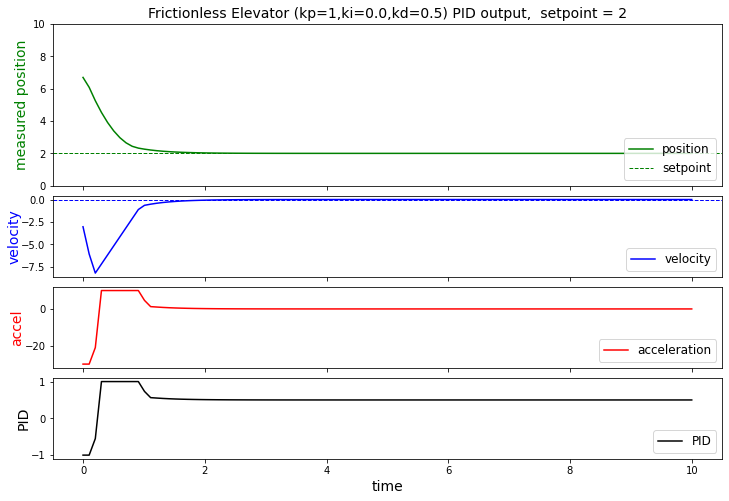

In [71]:
# initial conditions - you do not start at the setpoint
setpoint = 2
y_0 = 7

#Exercise: find the FFWD that works with this system
kp, ki, kd, ffwd  = 1, 0.0, 0.5, 0.5 # pure feed-forward, ? in this case balances gravity

# Exercise: tune the elevator
# kp, ki, kd, ffwd = 0.0, 0.0, 0.0, 0.0  # better

# run the simulation
_ = plot_elevator(kp=kp, ki=ki, kd=kd, ffwd=ffwd, setpoint=setpoint, y_0=y_0, label='Frictionless Elevator', motor_scale=2, autoscale=False)

<details>
<summary>Click here for spoilers for tuning this elevator </summary>
kp, ki, kd, ffwd  = 0, 0, 0, 0.5  # pure feed-forward, 0.5 in this case balances gravity<br>
kp, ki, kd, ffwd = 0.9, 0.0, 0.3, 0.5  # better elevator
</details>

---
#### here's some terminilogy to describe your system

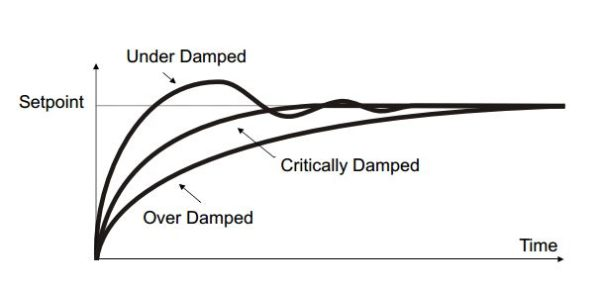

---
#### some tools from wpilib

In [72]:
import wpimath.controller as wc

In [18]:
# pc
# !pip install robotpy
# or !pip install robotpy[all]
#mac
#!pip install robotpy

#### here's a PID controller that you set gains and SP, then feed measurements and it gives you output

In [73]:
wc.PIDController?

Docstring:      Implements a PID control loop.
Init docstring:
__init__(self: wpimath._controls._controls.controller.PIDController, Kp: float, Ki: float, Kd: float, period: seconds = 0.02) -> None

Allocates a PIDController with the given constants for Kp, Ki, and Kd.

:param Kp:     The proportional coefficient.
:param Ki:     The integral coefficient.
:param Kd:     The derivative coefficient.
:param period: The period between controller updates in seconds. The
               default is 20 milliseconds. Must be non-zero and positive.
Type:           pybind11_type
Subclasses:     


#### see docs for feedforward - you have to understand your system
https://docs.wpilib.org/en/stable/docs/software/advanced-controls/controllers/feedforward.html

In [22]:
wc.SimpleMotorFeedforwardMeters?

Docstring:     
A helper class that computes feedforward voltages for a simple
permanent-magnet DC motor.
Init docstring:
__init__(*args, **kwargs)
Overloaded function.

1. __init__(self: wpimath._controls._controls.controller.SimpleMotorFeedforwardMeters) -> None

2. __init__(self: wpimath._controls._controls.controller.SimpleMotorFeedforwardMeters, kS: volts, kV: volt_seconds_per_meter, kA: volt_seconds_squared_per_meter = 0.0) -> None

Creates a new SimpleMotorFeedforward with the specified gains.

:param kS: The static gain, in volts.
:param kV: The velocity gain, in volt seconds per distance.
:param kA: The acceleration gain, in volt seconds^2 per distance.
Type:           pybind11_type
Subclasses:     
